In [22]:
import warnings
#warnings.filterwarnings("error")
import sys
sys.path.append('pysubgroup')
from RDMM.evaluation_framework import EvaluationFramework
from pathlib import Path
import numpy as np
import pandas as pd
from collections import namedtuple
from tqdm import tqdm
date_path=Path('06_04')
#folder= Path.home()/Path('experiments')/date_path
folder= "L:/"/Path('experiments')/'remote'/date_path
print(folder)
frame = EvaluationFramework(folder)
pd.set_option('display.max_colwidth', 100)

L:\experiments\remote\06_04


In [23]:
from RDMM.utils import *

In [24]:
num_dataframes = 10
num_parameters = 36
num_quality_pairs = 9
model_class=Path('regression')
#model_class=Path('transition')
#model_class=Path('cov')
#experiment_name="mine_pair_results"
experiment_name="exhaustive_results"

total_experiments=num_dataframes * num_parameters * num_quality_pairs
result_frames  = frame.evaluate_results(model_class,experiment_name, total_experiments, tqdm, allow_omit=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3240/3240 [01:38<00:00, 32.93it/s]


In [25]:
abbreviations={'LikelihoodExceptionality_transition':'Like',
'LikelihoodSimilarity':'Like',
'TotalVariationSimilarity': 'var',
 'TotalVariationExceptionality':'var',
 'ParameterDiff':'par',
 'ParameterDiff_sim':'par',
 'Cooks_sim':'Cooks',
 'Like_sim':'Like',
 'Log_sim':'Log',
 'par_sim':'par'} 

In [26]:
def unstack_index(df, fun):
    new_df = df.aggregate(fun, axis=1).unstack(['ex','sim'])
    new_df = new_df.reorder_levels(['gamma', 'beta','alpha'])
    return new_df.rename(columns=abbreviations)

In [27]:
evaluation_name='top10'
df = unstack_index(result_frames[evaluation_name], np.mean).sort_index()
df_std = unstack_index(result_frames[evaluation_name], np.std).sort_index()

In [28]:

import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

s = (df_std).style.background_gradient(cmap=cm)

In [29]:
display(s)

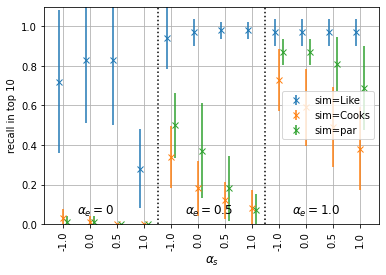

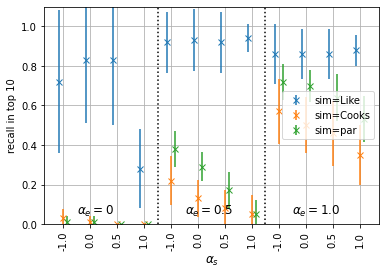

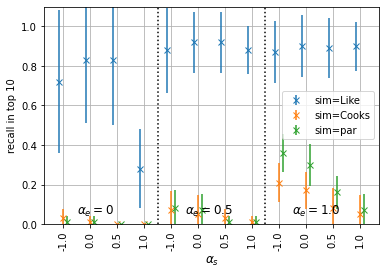

In [30]:
import matplotlib.pyplot as plt
show_reg=True

ex_selection="Like"
if show_reg:
    for ex_selection in ["Like", "Cooks", "par"]:
        fig=plt.figure()
        dx=0
        for sim_name, dx in zip(["Like","Cooks", "par"], 3*np.array([-0.05,0,0.05])):
            labels =[]
            values = []
            stds =[]
            for m, std in zip(df.xs(0.0, level="gamma").xs(ex_selection,level="ex", axis=1).itertuples(), df_std.xs(0.0, level="gamma").xs(ex_selection,level="ex", axis=1).itertuples()):
                assert m.Index==std.Index



                labels.append(tuple(m.Index))
                values.append(getattr(m,sim_name))
                stds.append(getattr(std,sim_name))
            x = np.arange(len(labels))
            plt.errorbar(x+dx, values, yerr=stds, fmt="x", label="sim="+sim_name)

        plt.ylim(0,1.1)
        xlabels=[l[1] for l in labels]
        plt.xticks(x, xlabels, rotation='vertical')
        plt.axvline(3.5,color='k',linestyle=':')
        plt.axvline(7.5,color='k',linestyle=':')
        plt.text(0.5,0.05, r"$\alpha_e=0$", fontsize=12)
        plt.text(4.5,0.05, r"$\alpha_e=0.5$", fontsize=12)
        plt.text(8.5,0.05, r"$\alpha_e=1.0$", fontsize=12)
        plt.legend(loc=5)
        plt.grid()
        plt.ylabel("recall in top 10")
        plt.xlabel(r"$\alpha_s$", fontsize=12)
        
        plt.savefig("L:/experiments"/Path('matplotlib_images')/f'synthetic-reg-top10-{experiment_name}-ex-{ex_selection}.png',bbox='tight',bbox_inches = 'tight')
        plt.show()
            

In [116]:

show_cov=False
if show_cov:
    labels =[]
    values = []
    stds =[]
    for m, std in zip(df.loc[0].itertuples(), df_std.loc[0].itertuples()):
        assert m.Index==std.Index
        labels.append(tuple(m.Index))
        values.append(m._1)
        stds.append(std._1)
    x = np.arange(len(labels))
    plt.errorbar(x, values, yerr=stds, fmt="x")
    plt.axvline(3.5,color='k',linestyle=':')
    plt.axvline(7.5,color='k',linestyle=':')
    xlabels=[l[1] for l in labels]
    plt.xticks(x, xlabels, rotation='vertical')
    d=0.2
    plt.text(0.5,0.05+d, r"$\alpha_e=0$", fontsize=12)
    plt.text(4.5,0.05+d, r"$\alpha_e=0.5$", fontsize=12)
    plt.text(8.5,0.05+d, r"$\alpha_e=1.0$", fontsize=12)
    plt.ylabel("recall in top 10")
    plt.xlabel(r"$\alpha_s$", fontsize=12)
    plt.grid()
    plt.savefig("L:/experiments"/Path('matplotlib_images')/f'synthetic-cov-top10-{experiment_name}.png',bbox='tight',bbox_inches = 'tight')
    plt.show()

In [34]:
if False:
    with open(Path.home()/Path('experiments')/date_path/model_class/(evaluation_name+'.tex'),'w') as outfile:
        outfile.write(df.sort_index().to_latex())

In [28]:
import math
def str_with_err(value, error):
    digits = -int(math.floor(math.log10(error)))
    return "{0:.{2}f}({1:.0f})".format(value, math.floor(error*10**digits), digits)

def to_k_digits(value,error,k):
    return "${0:.0f}\pm {1:02.0f}$".format(value*10**k, error*10**k, k)
def merge_mean_std(mean_df, std_df):
    new_tpls=[]
    for (row_mean,row_std) in zip(mean_df.itertuples(), std_df.itertuples()):
        new_tpls.append(tuple(to_k_digits(m,s,2) for m,s in zip(row_mean[1:],row_std[1:])))
    return pd.DataFrame.from_records(new_tpls, index = mean_df.index, columns=mean_df.columns)
df_merged=merge_mean_std(df,df_std)

In [29]:
print(df_merged.sort_index().to_latex(escape=False))


\begin{tabular}{llll}
\toprule
    &     & ex &      Norm 1 \\
    &     & sim &      Norm 1 \\
gamma & beta & alpha &             \\
\midrule
0.0 & 0.0 & -1.0 &  $18\pm 15$ \\
    &     &  0.0 &  $53\pm 28$ \\
    &     &  0.5 &  $49\pm 28$ \\
    &     &  1.0 &  $50\pm 29$ \\
    & 0.5 & -1.0 &  $64\pm 14$ \\
    &     &  0.0 &  $87\pm 19$ \\
    &     &  0.5 &  $79\pm 31$ \\
    &     &  1.0 &  $75\pm 36$ \\
    & 1.0 & -1.0 &  $92\pm 06$ \\
    &     &  0.0 &  $93\pm 13$ \\
    &     &  0.5 &  $91\pm 19$ \\
    &     &  1.0 &  $80\pm 34$ \\
0.5 & 0.0 & -1.0 &  $90\pm 14$ \\
    &     &  0.0 &  $43\pm 38$ \\
    &     &  0.5 &  $18\pm 36$ \\
    &     &  1.0 &   $2\pm 04$ \\
    & 0.5 & -1.0 &  $94\pm 10$ \\
    &     &  0.0 &  $56\pm 39$ \\
    &     &  0.5 &  $24\pm 36$ \\
    &     &  1.0 &   $7\pm 13$ \\
    & 1.0 & -1.0 &  $94\pm 10$ \\
    &     &  0.0 &  $72\pm 30$ \\
    &     &  0.5 &  $37\pm 38$ \\
    &     &  1.0 &  $15\pm 27$ \\
1.0 & 0.0 & -1.0 &  $12\pm 11$ \\
    &  

In [52]:
def add_colouring_to_table(df_str, df_mean, min_sat=0, max_sat=80):
    max_val=-10**10
    min_val=10**10
    for col in df_mean.columns:
        max_val=max(max_val, df_mean[col].max())
        min_val=min(min_val, df_mean[col].min())
    print(min_val, max_val)
    df_out=df_str.copy()
    for col in df_mean.columns:
        color_values=np.array(np.round(np.interp(np.power(df_mean[col].values,3),[0,1],[min_sat,max_sat])),dtype=int)
        color_strs=[]
        for i,val in enumerate(color_values):
            color_strs.append("\cellcolor{green!"+str(val)+"!white}"+str(df_str[col].values[i]))
        df_out[col]=color_strs
    return df_out
def highlight_max_values_in_column(df_str, df_mean):
    max_dict={col:df_mean[col].max() for col in df_mean.columns}

    df_out=df_str.copy()
    for col in df_mean.columns:
        should_highlight = df_mean[col].values==max_dict[col]
        for i,val in enumerate(df_mean[col]):
            if should_highlight[i]:
                 df_out[col][i]=r"\textbf{"+df_out[col].values[i]+"}"
    return df_out

def highlight_exceptionalities(df_str, df_mean,column_count):
    df_out=df_str.copy()
    for k in range(0,len(df_mean.columns),column_count):
        arrs=[]
        for j in range(0, column_count):
            arrs.append(df_mean[df_mean.columns[k+j]].to_numpy())
        maxes=np.argmax(np.array(arrs),axis=0)
        for j in range(0, column_count):
            col=df_mean.columns[k+j]
            values=df_out[col].to_numpy()
            for i in range(len(df_out)):
                if maxes[i]==j:
                    values[i]=r"\textit{"+values[i]+"}"
    return df_out
def apply_highlights(df_str,df_mean):
    return add_colouring_to_table(df_str,df_mean)

In [53]:
#print(highlight_exceptionalities(df_merged, df,3).to_latex(escape=False))

In [57]:
#del df, df_merged, df_std
if True:
    for evaluation_name in ['top10','top25','mir']:
        #evaluation_name='top10'
        df = unstack_index(result_frames[evaluation_name], np.mean).sort_index()
        df_std = unstack_index(result_frames[evaluation_name], np.std).sort_index()
        df_merged=merge_mean_std(df,df_std)
        df_out=apply_highlights(df_merged, df)
        suffix=''
        for i in range(0,len(df.columns),8):
            df_print=df_out[df_out.columns[i:i+8]]
            df_print.index=df_print.index.rename(map({'gamma':r'$\gamma$','beta':r'$\beta$','alpha':r'$\alpha$'}.get,df_print.index.names))
            suffix='_'+str(int(i/8))
            if i==0:
                suffix=''
            out_path=folder/model_class/(str(model_class)+'_'+experiment_name+'_'+evaluation_name+suffix)
            latex_path=Path(str(out_path)+'.tex')
            df_path=Path(str(out_path)+'.pickle')
            df_std_path=Path(str(out_path)+"_std"+'.pickle')
            with open(latex_path,'w') as outfile:
                print('writing to: ', latex_path)
                outfile.write(df_print.to_latex(escape=False))
            df.to_pickle(df_path)
            df_std.to_pickle(df_std_path)

0.0 0.9399999999999998
writing to:  L:\experiments\06_03\cov\cov_mine_pair5_results_top10.tex
0.0 0.99
writing to:  L:\experiments\06_03\cov\cov_mine_pair5_results_top25.tex
3.450939097724934 101.00000000000001
writing to:  L:\experiments\06_03\cov\cov_mine_pair5_results_mir.tex


In [15]:
display(result_frames['raw'].xs(0,level='beta').xs(0,level='gamma').xs('Like',level='ex'))

KeyError: 'Like'

In [ ]:
display(result_frames['raw'].xs(0,level='beta').xs(0,level='gamma').xs('Log',level='ex'))